# Predicting Tensile Capacity
Adhesive Anchors \\

Coded by Erick Melgarejo and Luis Bedriñana

Nov., 2023

Reference: Bedriñana et al. 2024 WCEE_v4


Change Log:

-

In [ ]:
 #Imports
import xgboost as xgb
import shap
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
from scipy.stats import norm
from scipy import interpolate
from statsmodels.formula.api import ols
%matplotlib inline

In [ ]:
# Setting for output figures
plt.close('all')
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

In [ ]:
# FUNCTIONS
# Function for figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "TensileStrength_v1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures_regression", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_pdf(fig_id, resolution=400,tight_layout=True,fig_extension="pdf"):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving pdf: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# Upload raw data
# You need to upload excel file to this colab file to run it by yourself
read_data = pd.read_csv('database.csv', delimiter=",")
read_data = read_data.iloc[:, 2:] #Remove the first two columns (source and data-code)
data_comp = read_data.copy() #Copia para uso futuro
print(read_data.head(10))
print(read_data.info())

      d  d_hole    hef  ad  fc_ad    fc  bar     fu     Nu  FM
0  36.0    56.0  288.0   1   54.0  25.0    0  490.0  242.0   2
1  36.0    56.0  288.0   1   54.0  25.0    0  490.0  242.0   0
2  36.0    56.0  288.0   1   54.0  25.0    0  490.0  273.0   0
3  36.0    56.0  288.0   1   54.0  25.0    1  490.0  467.0   2
4  36.0    56.0  288.0   1   54.0  25.0    1  490.0  467.0   0
5  36.0    56.0  288.0   1   54.0  25.0    1  490.0  424.0   2
6  36.0    56.0  432.0   1   54.0  25.0    0  490.0  300.0   0
7  36.0    56.0  432.0   1   54.0  25.0    0  490.0  324.0   0
8  36.0    56.0  432.0   1   54.0  25.0    0  490.0  318.0   0
9  36.0    56.0  432.0   1   54.0  25.0    1  490.0  400.0   2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   d       400 non-null    float64
 1   d_hole  400 non-null    float64
 2   hef     400 non-null    float64
 3   ad      400 

In [ ]:
# Making a copy of data - Just in case
data_mod = read_data.copy() #KNN Imputer

# Checking for missing data points
print(data_mod.isnull().sum())


d           0
d_hole      0
hef         0
ad          0
fc_ad     143
fc          0
bar         0
fu          0
Nu          0
FM          0
dtype: int64


In [ ]:
# Making a data imputation
# 3. Imputación KNN
imputer = KNNImputer(n_neighbors=100)
data_mod['fc_ad'] = imputer.fit_transform(data_mod[['ad', 'fc_ad']])[:, 1]
print(data_mod.isnull().sum())
data_mod.to_csv('archivo_complete.csv', index= False)

d         0
d_hole    0
hef       0
ad        0
fc_ad     0
fc        0
bar       0
fu        0
Nu        0
FM        0
dtype: int64


                d      d_hole          hef          ad       fc_ad  \
count  400.000000  400.000000   400.000000  400.000000  400.000000   
mean    19.795000   25.459500   180.642500    0.312500   70.980410   
std     20.912934   29.915483   225.581366    0.652617   10.520452   
min      6.000000    8.000000    18.000000    0.000000   50.000000   
25%     12.000000   12.700000    73.750000    0.000000   66.000000   
50%     15.900000   15.900000   101.600000    0.000000   75.600000   
75%     20.000000   24.000000   200.000000    0.000000   76.348000   
max    150.000000  210.000000  1800.000000    2.000000   90.800000   

               fc         bar           fu           Nu          FM  
count  400.000000  400.000000   400.000000   400.000000  400.000000  
mean    36.529650    1.517500  1109.415450   157.510475    1.665000  
std     17.698462    0.886939  1096.120212   391.865052    1.325582  
min      8.000000    0.000000   326.090000     5.800000    0.000000  
25%     25.000000  

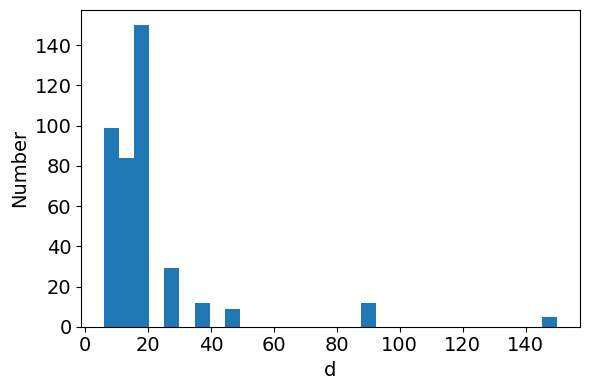

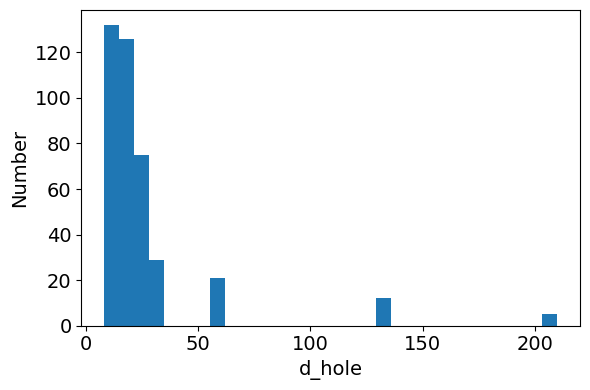

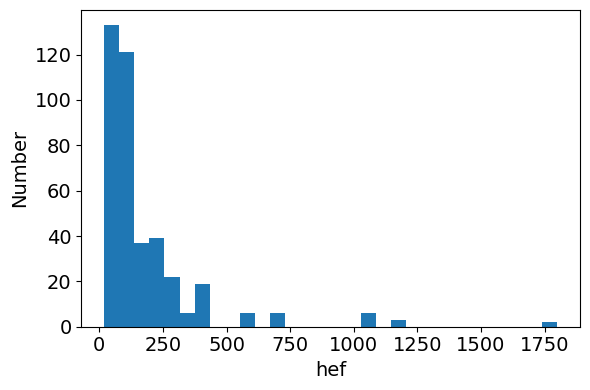

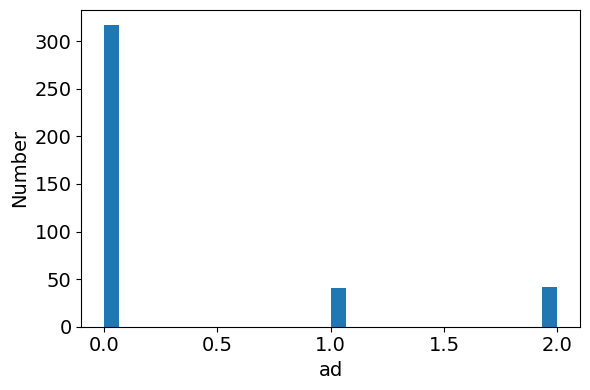

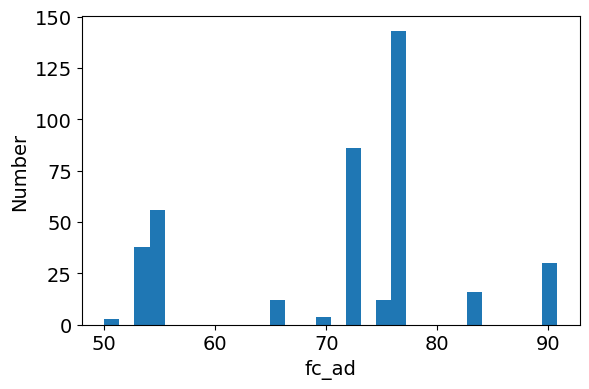

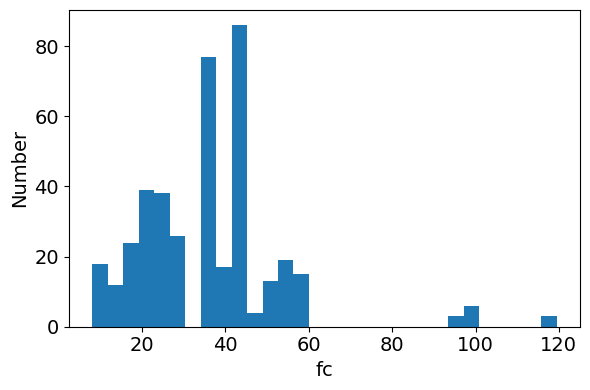

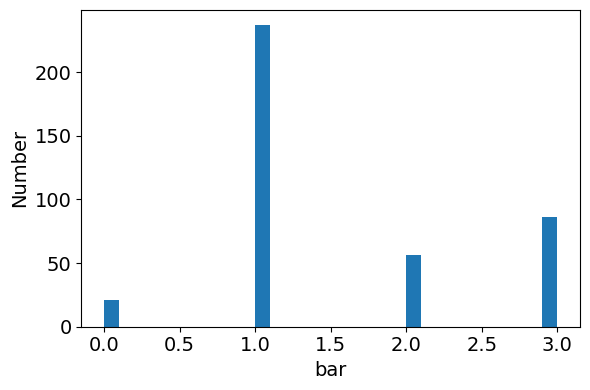

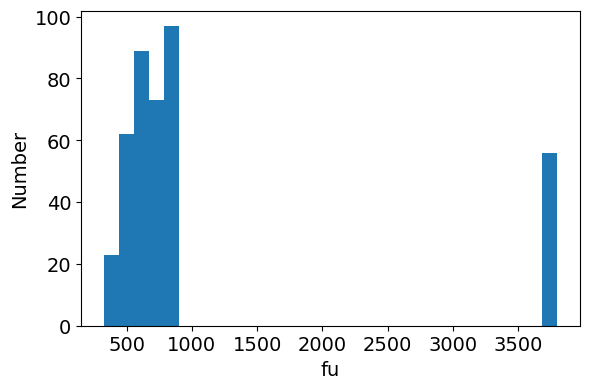

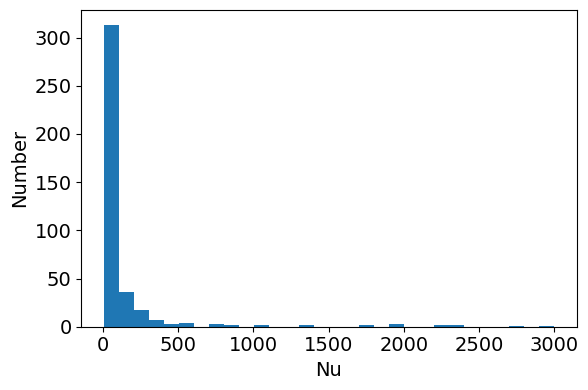

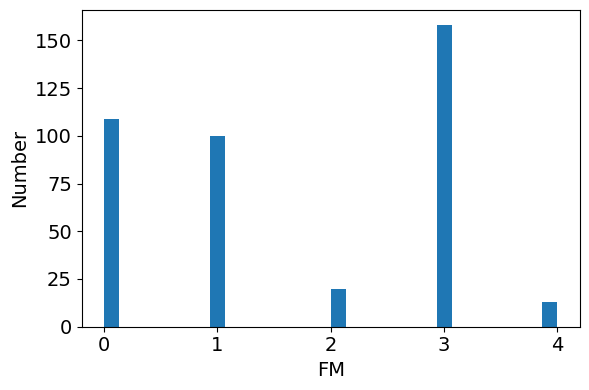

In [ ]:
# ==== Part 2: Initial Data exploration
# Output of Initial data statistics of KNN imputer dataset
TABLES_PATH = os.path.join(PROJECT_ROOT_DIR, "Tables_Output_Regression")
os.makedirs(TABLES_PATH, exist_ok=True)
file_table = path = os.path.join(TABLES_PATH, 'initial_DataStats.csv')
Data_statistics = data_mod.describe()
Data_statistics.to_csv(path_or_buf=file_table)
print(Data_statistics)
# Plots - histograms of original features
for xx in data_mod.columns:
    plt.figure(figsize=(6,4))
    plt.hist(data_mod[xx],bins=30)
    plt.ylabel("Number", fontsize=14)
    plt.xlabel(xx, fontsize=14)
    save_fig("histogram_plot_"+xx)

In [ ]:
#---- Applying the ANOVA F-test
results = []
for column in data_mod.columns[:-2]:  # Excluye la última columna que es la variable dependiente
    model = ols(f'Nu ~ {column}', data=data_mod).fit()
    results.append({
        'Variable': column,
        'F-value': model.fvalue,
        'p-value': model.f_pvalue
    })

# Crea un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Ordena los resultados por p-value
results_df = results_df.sort_values(by='p-value')

print(results_df)


  Variable      F-value        p-value
1   d_hole  4584.953487  1.572385e-220
0        d  3862.542134  5.446695e-207
2      hef  2126.584583  9.543607e-162
4    fc_ad    66.864471   3.938569e-15
3       ad    37.297295   2.413799e-09
6      bar    31.077538   4.580793e-08
7       fu    14.693534   1.469619e-04
5       fc    11.026528   9.810871e-04


--- Initial Correlation Matrix
               d    d_hole       hef        ad     fc_ad        fc       bar  \
d       1.000000  0.994489  0.926711  0.293122 -0.467019 -0.186231 -0.297556   
d_hole  0.994489  1.000000  0.928398  0.293276 -0.434366 -0.216720 -0.331784   
hef     0.926711  0.928398  1.000000  0.313750 -0.319977 -0.260460 -0.287959   
ad      0.293122  0.293276  0.313750  1.000000 -0.233386  0.074469  0.356403   
fc_ad  -0.467019 -0.434366 -0.319977 -0.233386  1.000000 -0.213111 -0.103717   
fc     -0.186231 -0.216720 -0.260460  0.074469 -0.213111  1.000000  0.389949   
bar    -0.297556 -0.331784 -0.287959  0.356403 -0.103717  0.389949  1.000000   
fu     -0.128520 -0.179561 -0.275401 -0.209033 -0.593202  0.321904  0.235648   
Nu      0.952147  0.959233  0.917796  0.292715 -0.379258 -0.164189 -0.269126   
FM      0.107208  0.097315  0.068842 -0.139423 -0.202543 -0.232080 -0.076006   

              fu        Nu        FM  
d      -0.128520  0.952147  0.107208  
d_hole -0.

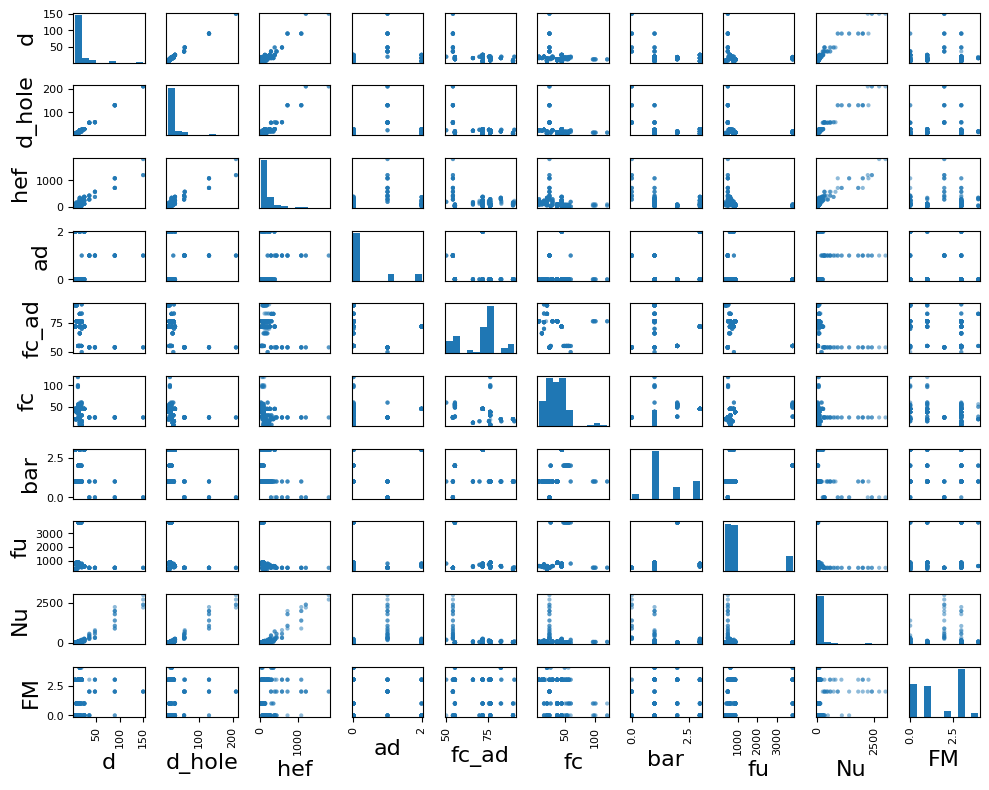

In [ ]:
# Getting initial correlation matrix - KNN Imputer
Init_corr = data_mod.corr()
print("--- Initial Correlation Matrix")
print(Init_corr)
file_table = path = os.path.join(TABLES_PATH, 'initial_correlation.csv')
Init_corr.to_csv(path_or_buf=file_table)
scatter_matrix(data_mod, figsize=(10, 8))
save_fig("scatter_matrix_plot")

count     400.000000
mean      157.510475
std       391.865052
min         5.800000
25%        29.110000
50%        50.640000
75%        93.927500
max      3000.000000
Name: Nu, dtype: float64
d            0
d_hole       0
hef          0
ad           0
fc_ad        0
fc           0
bar          0
fu           0
Nu           0
FM           0
strata_Nu    0
dtype: int64


count     400
unique      5
top         4
freq       96
Name: strata_Nu, dtype: int64

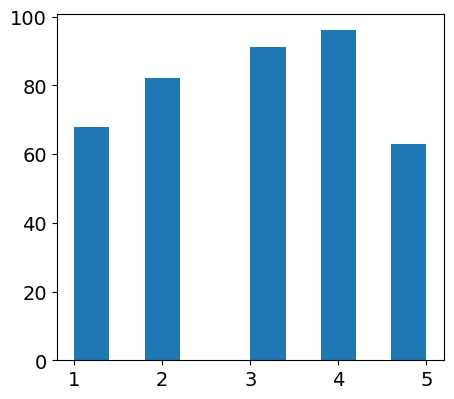

In [ ]:
# ------- Definition of strata for split of data - Based on Nu
print(data_mod['Nu'].describe())
# Defining range for strata
bins = [5,20,40,70, 150, 3000]
names = [1,2,3,4, 5]
data_mod["strata_Nu"] = pd.cut(data_mod['Nu'],bins,labels = names)
# Checking for missing data points
print(data_mod.isnull().sum())
plt.figure(figsize=(5,4.5))
plt.hist(data_mod["strata_Nu"])
data_mod["strata_Nu"].describe()

In [ ]:
# Now data_mod includes categorical values for strata_Nu
data_mod

,d,d_hole,hef,ad,fc_ad,fc,bar,fu,Nu,FM,strata_Nu
0,36.0,56.0,288.0,1,54.0,25.0,0,490.0,242.0,2,5
1,36.0,56.0,288.0,1,54.0,25.0,0,490.0,242.0,0,5
2,36.0,56.0,288.0,1,54.0,25.0,0,490.0,273.0,0,5
3,36.0,56.0,288.0,1,54.0,25.0,1,490.0,467.0,2,5
4,36.0,56.0,288.0,1,54.0,25.0,1,490.0,467.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
395,16.0,22.0,160.0,0,66.0,12.7,1,586.7,82.3,3,4
396,16.0,22.0,160.0,0,66.0,12.7,1,606.9,69.8,3,3
397,16.0,22.0,192.0,0,66.0,12.7,1,552.0,91.6,3,4
398,16.0,22.0,192.0,0,66.0,12.7,1,586.7,88.5,3,4


--- Initial Correlation Matrix
               d    d_hole       hef        ad     fc_ad        fc       bar  \
d       1.000000  0.994489  0.926711  0.293122 -0.467019 -0.186231 -0.297556   
d_hole  0.994489  1.000000  0.928398  0.293276 -0.434366 -0.216720 -0.331784   
hef     0.926711  0.928398  1.000000  0.313750 -0.319977 -0.260460 -0.287959   
ad      0.293122  0.293276  0.313750  1.000000 -0.233386  0.074469  0.356403   
fc_ad  -0.467019 -0.434366 -0.319977 -0.233386  1.000000 -0.213111 -0.103717   
fc     -0.186231 -0.216720 -0.260460  0.074469 -0.213111  1.000000  0.389949   
bar    -0.297556 -0.331784 -0.287959  0.356403 -0.103717  0.389949  1.000000   
fu     -0.128520 -0.179561 -0.275401 -0.209033 -0.593202  0.321904  0.235648   
Nu      0.952147  0.959233  0.917796  0.292715 -0.379258 -0.164189 -0.269126   
FM      0.107208  0.097315  0.068842 -0.139423 -0.202543 -0.232080 -0.076006   

              fu        Nu        FM  
d      -0.128520  0.952147  0.107208  
d_hole -0.

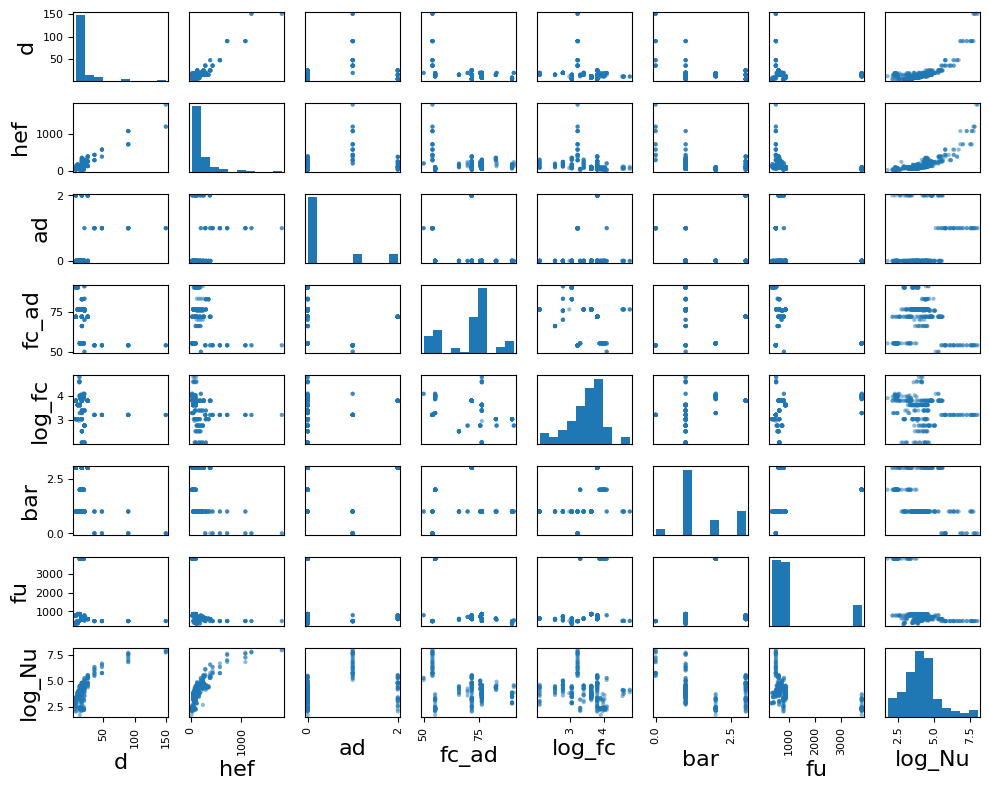

In [ ]:
# Making some modifications to feature - Increasing correlation
# converting to log some features
var_names_to_log = [ 'fc' , 'Nu' ]
data_mod_log = data_mod.copy()
for feature in var_names_to_log:
    data_mod_log[feature] = np.log(data_mod_log[feature])
# Total List of features
names2 = ['d', 'd_hole', 'hef', 'ad', 'fc_ad', 'log_fc', 'bar', 'fu', 'log_Nu', 'FM',
           'strata_fc']
data_mod_log.columns = names2
# List of features with only numerical value
names_num = ['d', 'hef', 'ad', 'fc_ad', 'log_fc', 'bar', 'fu', 'log_Nu']

# Getting correlation matrix for new features
New_corr = data_mod_log[names_num].corr()
print("--- Initial Correlation Matrix")
print(Init_corr)
print("--- New Correlation Matrix")
print(New_corr)
scatter_matrix(data_mod_log[names_num], figsize=(10, 8))
save_fig("New_scatter_matrix_plot")

Saving figure:  correlation_matrix_with_output


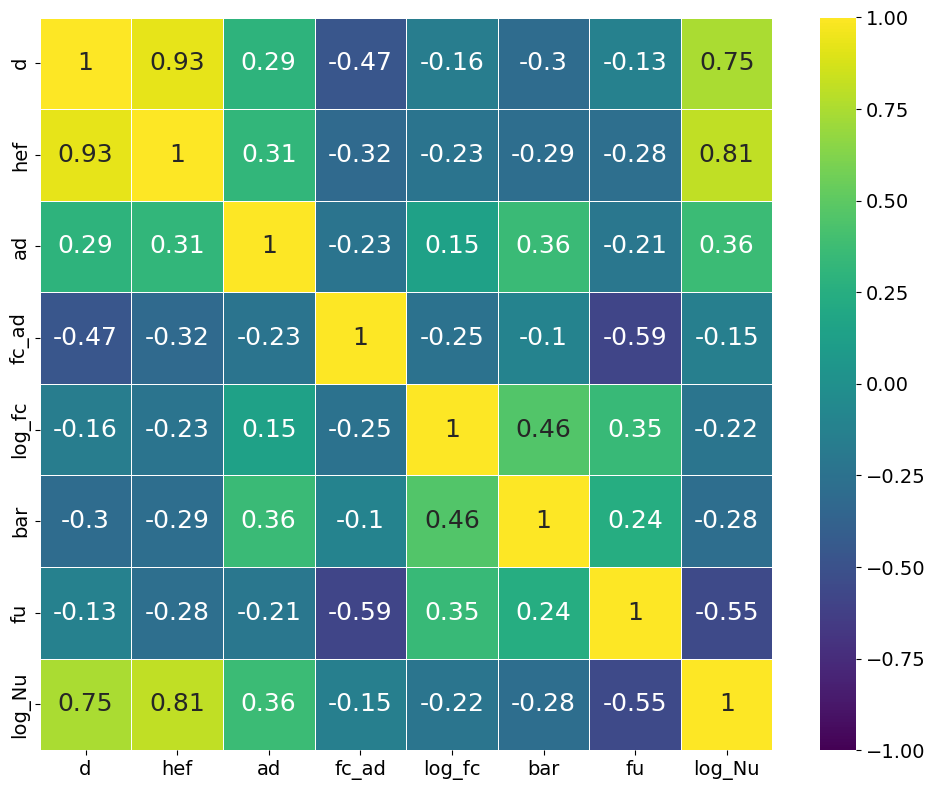

In [ ]:
# Visualization of correlation among final attributes
plt.figure(figsize=(10, 8))
sns.heatmap(data_mod_log[names_num].corr(), annot=True, fmt='.2g', center= 0,
    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.6, square=True,
            annot_kws={"size": 18}, xticklabels=names_num, yticklabels=names_num)
save_fig("correlation_matrix_with_output")

In [ ]:
# ================ Part 3: Preparing data for ML models
# Defining final inputs and output
Input_var = ['d', 'hef','ad', 'fc_ad', 'log_fc', 'bar', 'fu']
Target_var = ['log_Nu']
X_data = data_mod_log[Input_var]
Y_data = data_mod_log[Target_var]
X_data

,d,hef,ad,fc_ad,log_fc,bar,fu
0,36.0,288.0,1,54.0,3.218876,0,490.0
1,36.0,288.0,1,54.0,3.218876,0,490.0
2,36.0,288.0,1,54.0,3.218876,0,490.0
3,36.0,288.0,1,54.0,3.218876,1,490.0
4,36.0,288.0,1,54.0,3.218876,1,490.0
...,...,...,...,...,...,...,...
395,16.0,160.0,0,66.0,2.541602,1,586.7
396,16.0,160.0,0,66.0,2.541602,1,606.9
397,16.0,192.0,0,66.0,2.541602,1,552.0
398,16.0,192.0,0,66.0,2.541602,1,586.7


In [ ]:
# Split of dataset
# You can choose the variable for strata
# Note: Using a strattified random shuffle split of data - 8:2 ratio
# Note: Using strata based on fc
XX_train, XX_test, YY_train, YY_test = train_test_split(
    X_data, Y_data, test_size=0.2, random_state=42,
    stratify=data_mod['strata_Nu'])
YY_train

,log_Nu
375,4.354655
274,3.836221
339,4.987708
164,4.890349
188,4.454347
...,...
53,2.322388
135,4.515245
226,3.433987
223,2.687847


In [ ]:
# === Definition of main scaler for training models
# Notes:
# - Scaler only affects X data in train set
# - Use the same scaler for new data
# - Standard scaler for features
# - Save parameters of scalers for the interface

scaler = StandardScaler()
X_train_slr = scaler.fit(XX_train)
print("--- Mean values of data ---")
print(X_train_slr.mean_)
print("--- Variance of data ---")
print(X_train_slr.var_)
print("--- STD (scale factor) for data ---")
print(X_train_slr.scale_)


--- Mean values of data ---
[1.92959375e+01 1.76698750e+02 3.00000000e-01 7.09482000e+01
 3.48225237e+00 1.51250000e+00 1.12901987e+03]
--- Variance of data ---
[3.96753702e+02 4.73861977e+04 4.10000000e-01 1.13233425e+02
 2.80469739e-01 7.74843750e-01 1.24805653e+06]
--- STD (scale factor) for data ---
[1.99186772e+01 2.17683710e+02 6.40312424e-01 1.06411196e+01
 5.29593938e-01 8.80252095e-01 1.11716450e+03]


In [ ]:
# - Scaler only affects X data - Full data

X_data_slr = StandardScaler(with_mean=True, with_std = True).fit(X_data)
print("--- Mean values of data ---")
print(X_data_slr.mean_)
print("--- Variance of data ---")
print(X_data_slr.var_)
print("--- STD (scale factor) for data ---")
print(X_data_slr.scale_)

--- Mean values of data ---
[1.97950000e+01 1.80642500e+02 3.12500000e-01 7.09804100e+01
 3.47645217e+00 1.51750000e+00 1.10941545e+03]
--- Variance of data ---
[4.36257425e+02 5.07597353e+04 4.24843750e-01 1.10403211e+02
 2.72011220e-01 7.84693750e-01 1.19847582e+06]
--- STD (scale factor) for data ---
[2.08867763e+01 2.25299213e+02 6.51800391e-01 1.05072932e+01
 5.21546949e-01 8.85829414e-01 1.09474920e+03]


In [ ]:
# Checking differences in scaler - test Data
X_test_slr = scaler.fit(XX_test)
print("--- Mean values of data ---")
print(X_test_slr.mean_)
print("--- Variance of data ---")
print(X_test_slr.var_)
print("--- STD (scale factor) for data ---")
print(X_test_slr.scale_)

--- Mean values of data ---
[2.17912500e+01 1.96417500e+02 3.62500000e-01 7.11092500e+01
 3.45325137e+00 1.53750000e+00 1.03099775e+03]
--- Variance of data ---
[5.89291048e+02 6.39428222e+04 4.81093750e-01 9.90616034e+01
 2.37504296e-01 8.23593750e-01 9.92466323e+05]
--- STD (scale factor) for data ---
[2.42753177e+01 2.52869180e+02 6.93609220e-01 9.95296958e+00
 4.87344125e-01 9.07520661e-01 9.96226040e+02]


                d         hef          ad       fc_ad      log_fc         bar  \
count  320.000000  320.000000  320.000000  320.000000  320.000000  320.000000   
mean    -0.102792   -0.077980   -0.090108   -0.016181    0.059508   -0.027548   
std      0.821817    0.862203    0.924606    1.070815    1.088396    0.971472   
min     -0.650506   -0.705572   -0.522629   -2.120900   -2.818973   -1.694176   
25%     -0.429088   -0.485103   -0.522629   -0.513339   -0.480924   -0.592273   
50%     -0.242685   -0.374967   -0.522629    0.451197    0.355438   -0.592273   
75%     -0.073789    0.014167   -0.522629    0.526350    0.725178    0.509630   
max      5.281445    6.341550    2.360839    1.978379    2.729211    1.611534   

               fu  
count  320.000000  
mean     0.098393  
std      1.123153  
min     -0.707578  
25%     -0.435642  
50%     -0.335765  
75%     -0.169738  
max      2.779492  


array([[<Axes: title={'center': 'd'}>, <Axes: title={'center': 'hef'}>,
        <Axes: title={'center': 'ad'}>],
       [<Axes: title={'center': 'fc_ad'}>,
        <Axes: title={'center': 'log_fc'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'fu'}>, <Axes: >, <Axes: >]], dtype=object)

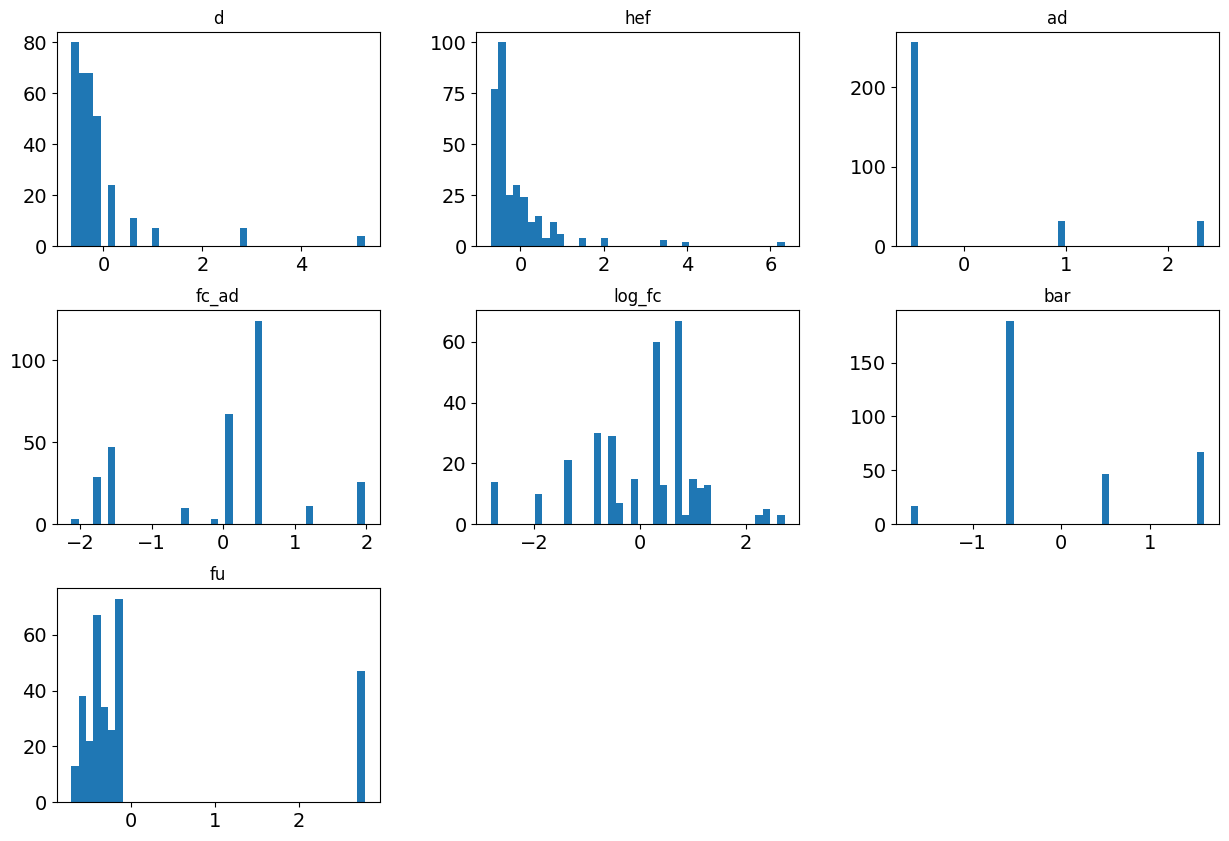

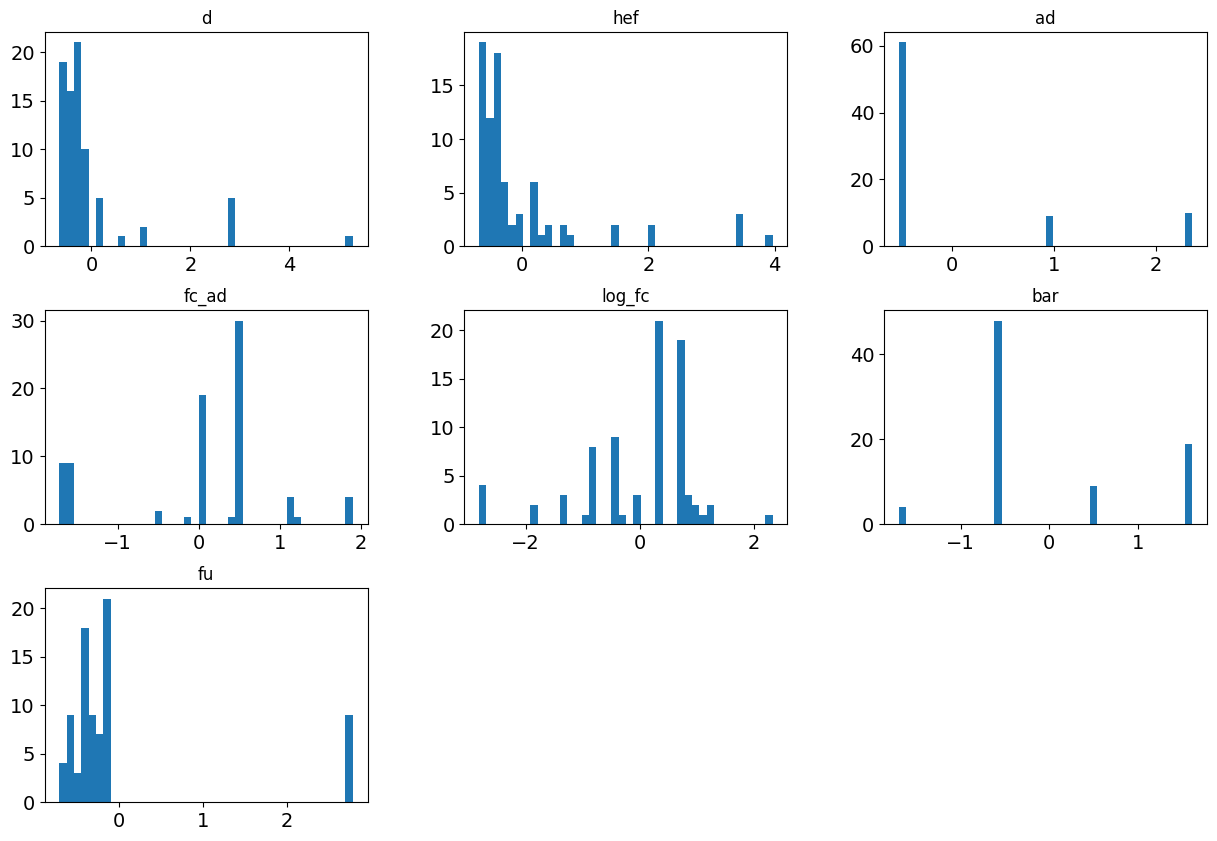

In [ ]:
# Applying the main scaler to both datasets
XX_train_sca = pd.DataFrame(X_train_slr.transform(XX_train), columns = Input_var)
XX_test_sca = pd.DataFrame(X_train_slr.transform(XX_test), columns = Input_var)
print(XX_train_sca.describe())
XX_train_sca.hist(bins=40, figsize=(15,10), grid=False)
XX_test_sca.hist(bins=40, figsize=(15,10), grid=False)

In [ ]:
# ==== Part 4: Training ML models
# Functions for Performance metrics
# Mean Average Relative Difference (MARD)

#Indicators were modifided to transform from logNu to Nu
def r2_LOG(X, Y):
    pred = np.array(np.exp(Y))
    real = np.array(np.exp(X))
    dif = real - pred
    r2 = 1 - (np.sum(dif**2) / np.sum((real - np.mean(real))**2))
    return r2

def rmse_LOG(X, Y):
    pred = np.array(np.exp(Y))
    real = np.array(np.exp(X))
    dif = real - pred
    rmse = np.sqrt(np.mean(dif**2))
    return rmse


def mard_LOG(X, Y):
    pred = np.array(np.exp(Y))
    real = np.array(np.exp(X))
    n = len(Y) #finding total number of items in list
    ard=[]
    for i in range(n):
        difference=np.abs(pred[i]-real[i])
        div=np.abs(difference/real[i])
        ard.append(div)
    mard_=np.median(ard)
    return(mard_)
#D%
def D_percentage_LOG(X, Y, Z=25):
    pred = np.array(np.exp(Y))
    real = np.array(np.exp(X))
    n = len(Y) #finding total number of items in list
    contador=0
    for i in range(n):
        difference=np.abs(pred[i]-real[i])
        div=np.abs(difference/real[i])
        if div<=(Z/100):
            contador+=1
    D_percent=contador/n
    return(D_percent*100)

#
def display_scores(scores):
    mean_r2= scores["test_r2"].mean()
    standard_deviation_r2= scores["test_r2"].std()
    mean_rmse= scores["test_rmse"].mean()
    standard_deviation_rmse= scores["test_rmse"].std()
    mean_mard= scores["test_mard"].mean()
    standard_deviation_mard= scores["test_mard"].std()
    mean_D_percentage= scores["test_D%"].mean()
    standard_deviation_D_percentage= scores["test_D%"].std()
    return [round(mean_r2,5),round(standard_deviation_r2,5),
            round(mean_rmse,5),round(standard_deviation_rmse,5),
            round(mean_mard,5),round(standard_deviation_mard,5),
            round(mean_D_percentage,5),round(standard_deviation_D_percentage,5)]
#

In [ ]:
# Performing the Cross-Validation of 3 models
# Note: the error in metrics is measured in terms of Nu
Validation_chart=[]
K_fold = 10 #Al alternar resulta 10, como la mejor opción
scoring = {'mard': make_scorer(mard_LOG),
           'D%': make_scorer(D_percentage_LOG),
           'r2': make_scorer(r2_LOG),
           'rmse': make_scorer(rmse_LOG)
           }
# Random Forest
RF_reg = RandomForestRegressor(random_state=42)
rf_cv = cross_validate(RF_reg, XX_train_sca, YY_train.to_numpy().ravel(), scoring=scoring, cv=K_fold, error_score='raise')
Validation_chart.append(display_scores(rf_cv))
# GBM
GBM_reg = GradientBoostingRegressor(random_state=42)
gbm_cv = cross_validate(GBM_reg, XX_train_sca, YY_train.to_numpy().ravel(), scoring=scoring, cv=K_fold, error_score='raise')
Validation_chart.append(display_scores(gbm_cv))
# CatBoost
CB_reg = CatBoostRegressor(random_state=42, silent = True)
cb_cv = cross_validate(CB_reg, XX_train_sca, YY_train.to_numpy().ravel(), scoring=scoring, cv=K_fold, error_score='raise')
Validation_chart.append(display_scores(cb_cv))
# XG Boost
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_cv = cross_validate(xgb_reg, XX_train_sca, YY_train.to_numpy().ravel(), scoring=scoring, cv=K_fold, error_score='raise')
Validation_chart.append(display_scores(xgb_cv))
Validation_chart

[[0.94531, 0.03165, 63.48019, 32.99196, 0.10145, 0.02613, 80.625, 4.59279],
 [0.95293, 0.03022, 54.70748, 25.9067, 0.11201, 0.02672, 79.0625, 5.04859],
 [0.95482, 0.03321, 52.32924, 20.11982, 0.09514, 0.02126, 79.6875, 4.25046],
 [0.95261, 0.03859, 52.82087, 17.95101, 0.09466, 0.02008, 81.5625, 5.12538]]

Saving figure:  CV_training_R2
Saving figure:  CV_training_RMSE
Saving figure:  CV_training_MARD
Saving figure:  CV_training_D%


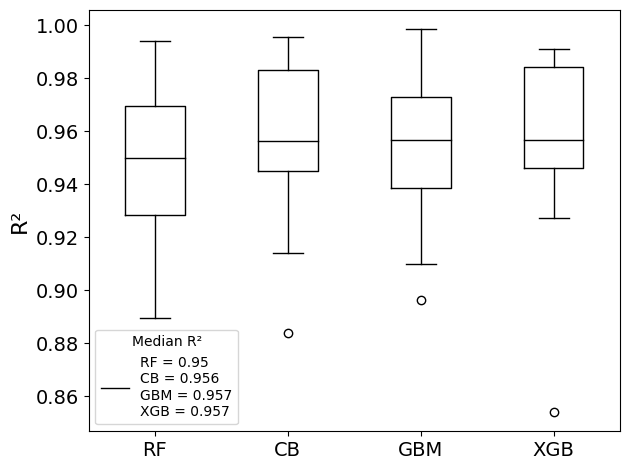

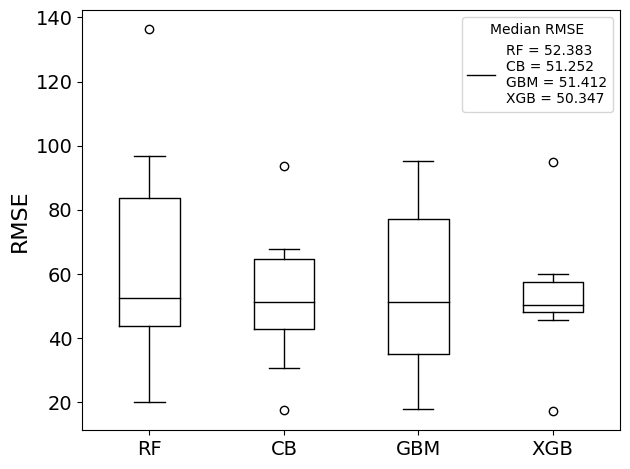

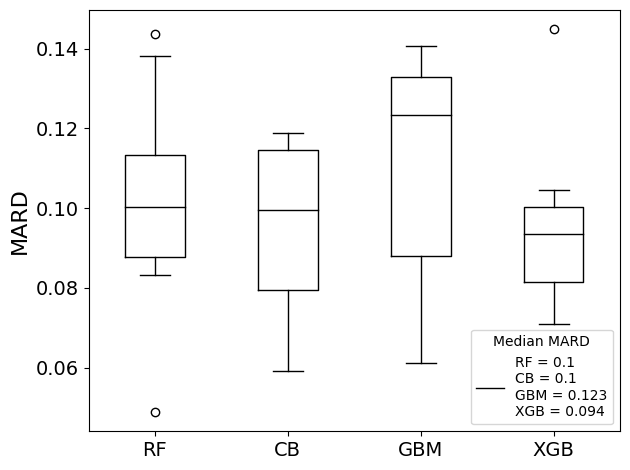

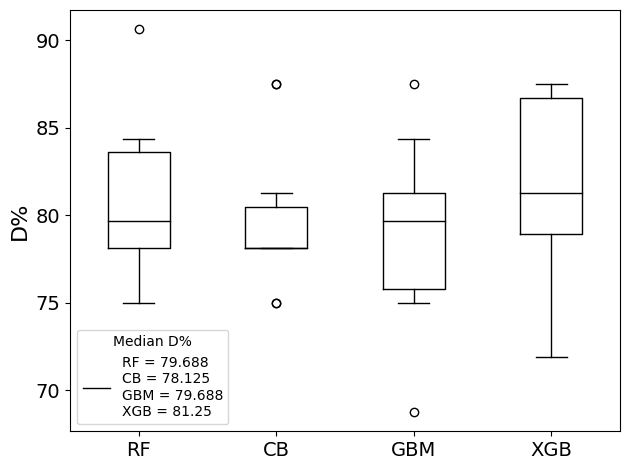

In [ ]:
# Plot of results from Cross-Validation
for i in ["test_r2"]:
    plt.figure()
    plt.boxplot([rf_cv[i], cb_cv[i], gbm_cv[i], xgb_cv[i]], whis=1,medianprops=dict(color="black"))
    legend = 'RF = '+ str(round(np.median(rf_cv["test_r2"]),3)) + "\n" \
       + 'CB = '+ str(round(np.median(cb_cv["test_r2"]),3)) + "\n" \
       + 'GBM = '+ str(round(np.median(gbm_cv["test_r2"]),3)) + "\n" \
       + 'XGB = '+ str(round(np.median(xgb_cv["test_r2"]),3))
    plt.xticks([1, 2, 3, 4], ['RF','CB', 'GBM', 'XGB'])
    plt.yticks()
    plt.legend([legend],title='Median R²')
    plt.ylabel("R²")
    save_fig("CV_training_R2")

for i in ["test_rmse"]:
    plt.figure()
    plt.boxplot([rf_cv[i], cb_cv[i], gbm_cv[i], xgb_cv[i]], whis=1,medianprops=dict(color="black"))
    legend = 'RF = '+ str(round(np.median(rf_cv["test_rmse"]),3)) + "\n" \
       + 'CB = '+ str(round(np.median(cb_cv["test_rmse"]),3)) + "\n" \
       + 'GBM = '+ str(round(np.median(gbm_cv["test_rmse"]),3)) + "\n" \
       + 'XGB = '+ str(round(np.median(xgb_cv["test_rmse"]),3))
    plt.xticks([1, 2, 3, 4], ['RF', 'CB', 'GBM', 'XGB'])
    plt.yticks()
    plt.legend([legend],title='Median RMSE')
    plt.ylabel("RMSE")
    save_fig("CV_training_RMSE")

for i in ["test_mard"]:
    plt.figure()
    plt.boxplot([rf_cv[i], cb_cv[i], gbm_cv[i], xgb_cv[i]], whis=1,medianprops=dict(color="black"))
    legend = 'RF = '+ str(round(np.median(rf_cv["test_mard"]),3)) + "\n" \
       + 'CB = '+ str(round(np.median(cb_cv["test_mard"]),3)) + "\n" \
       + 'GBM = '+ str(round(np.median(gbm_cv["test_mard"]),3)) + "\n" \
       + 'XGB = '+ str(round(np.median(xgb_cv["test_mard"]),3))
    plt.xticks([1, 2, 3, 4], ['RF','CB', 'GBM', 'XGB'])
    plt.yticks()
    plt.legend([legend],title='Median MARD')
    plt.ylabel("MARD")
    save_fig("CV_training_MARD")

for i in ["test_D%"]:
    plt.figure()
    plt.boxplot([rf_cv[i], cb_cv[i], gbm_cv[i], xgb_cv[i]], whis=1,medianprops=dict(color="black"))
    legend = 'RF = '+ str(round(np.median(rf_cv["test_D%"]),3)) + "\n" \
       + 'CB = '+ str(round(np.median(cb_cv["test_D%"]),3)) + "\n" \
       + 'GBM = '+ str(round(np.median(gbm_cv["test_D%"]),3)) + "\n" \
       + 'XGB = '+ str(round(np.median(xgb_cv["test_D%"]),3))
    plt.xticks([1, 2, 3, 4], ['RF','CB', 'GBM', 'XGB'])
    plt.yticks()
    plt.legend([legend],title='Median D%')
    plt.ylabel("D%")
    save_fig("CV_training_D%")

In [ ]:
# ============ Part 5:Tuning of the candidate ML model - XGBoost
# Checking for best hyperparameters with GridSearch
param_grid = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth':[2, 3, 4, 5],
              'n_estimators': [20, 30, 50, 60, 80, 100, 120, 150, 180, 200],
              'min_child_weight' : [2, 4, 5]}
print(xgb_reg.get_params())
grid_search = GridSearchCV(xgb_reg, param_grid, cv=K_fold,
                           scoring="r2",return_train_score=True
                           , verbose=1)
grid_search.fit(XX_train_sca, YY_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
{'learning_rate': 0.3, 'max_depth': 

In [ ]:
#============ Part 7: Validation of model with the testset
final_model = grid_search.best_estimator_
# Predictions in the training set
YY_pred_final = final_model.predict(XX_train_sca)
YY_train_final = YY_train['log_Nu']
#
# NOTE: Prediction errors are in terms of Nu
final_rmse = rmse_LOG(YY_train_final, YY_pred_final)
final_R2 = r2_LOG(YY_train_final, YY_pred_final)
final_mard=mard_LOG(YY_train_final, YY_pred_final)
final_D=D_percentage_LOG(YY_train_final, YY_pred_final,25)
print('TRAINING SET')
print("Root_mean_squared_error: ", final_rmse)
print("R2: ", final_R2)
print("MARD: ", final_mard)
print("D%: ", final_D)
# Predictions in the testing set
YY_predtest_final = final_model.predict(XX_test_sca)
YY_test_final = YY_test['log_Nu']
final_test_rmse = rmse_LOG(YY_test_final, YY_predtest_final)
final_test_R2 = r2_LOG(YY_test_final, YY_predtest_final)
final_test_mard=mard_LOG(YY_test_final, YY_predtest_final)
final_test_D=D_percentage_LOG(YY_test_final, YY_predtest_final,25)
print('-----------------------')
print('TESTING SET')
print("Root_mean_squared_error: ", final_test_rmse)
print("R2: ", final_test_R2)
print("MARD: ", final_test_mard)
print("D%: ", final_test_D)
print('-----------------------')

TRAINING SET
Root_mean_squared_error:  34.877027983744476
R2:  0.9903689368582907
MARD:  0.07790641116424706
D%:  90.0
-----------------------
TESTING SET
Root_mean_squared_error:  39.24809174208824
R2:  0.9940115889958158
MARD:  0.10731010768705687
D%:  83.75
-----------------------


Saving figure:  Regression_FinalXGB_plot


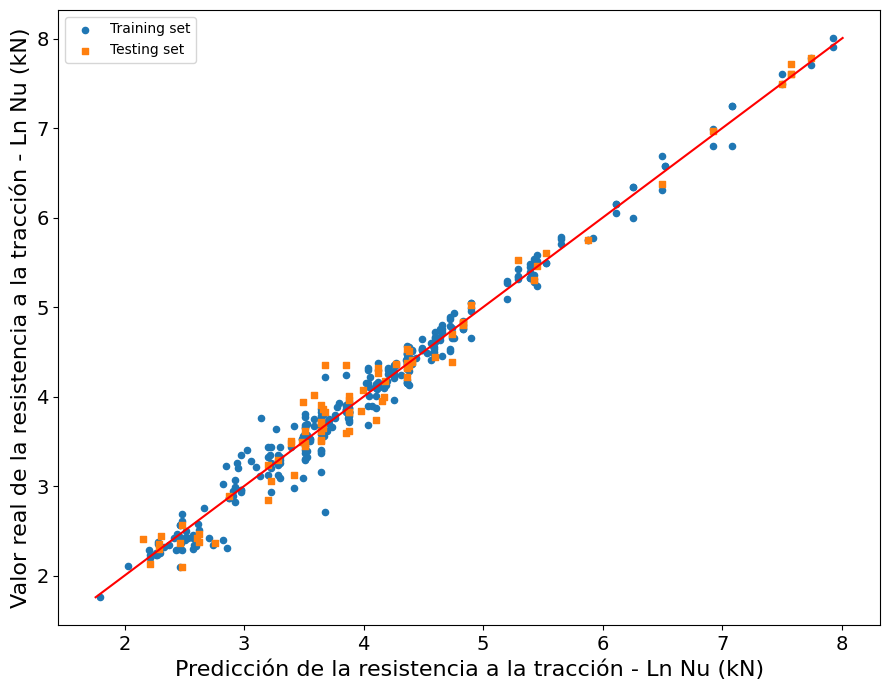

In [ ]:
# Plot of final performance
cLegend = "Training set metrics:" + "\n" \
        + "RMSE =  " + str(round(final_rmse,1)) + "\n" \
        + "R²      = " + str(round(final_R2,2)) + "\n" \
        + "MARD = " + str(round(final_mard,2)) + "\n" \
        + "D10% = " + str(round(final_D,2)) + '%'+  "\n" \
        + "\n" \
        + "Testing set metrics:" + "\n" \
        + "RMSE =  " + str(round(final_test_rmse,1)) + "\n" \
        + "R²      = " + str(round(final_test_R2,2)) + "\n" \
        + "MARD = " + str(round(final_test_mard,2)) + "\n" \
        + "D10% = " + str(round(final_test_D,2)) +'%'
Val_min = min(YY_train_final.min(),YY_pred_final.min(), YY_predtest_final.min(),
              YY_test_final.min())
Val_max = max(YY_train_final.max(),YY_pred_final.max(), YY_predtest_final.max(),
              YY_test_final.max())
plt.figure(figsize=(9,7))
plt.scatter(YY_pred_final, YY_train_final, label='Training set',s=20) # train
plt.scatter(YY_predtest_final, YY_test_final, marker="s",s=20,label='Testing set') # test
plt.plot(np.linspace(Val_min, Val_max, num=10),np.linspace(Val_min, Val_max, num=10), color='red')
plt.xlabel("Predicción de la resistencia a la tracción - Ln Nu (kN)")
plt.ylabel("Valor real de la resistencia a la tracción - Ln Nu (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
save_fig("Regression_FinalXGB_plot")
plt.show()

Saving figure:  Regression_FinalXGB_plot


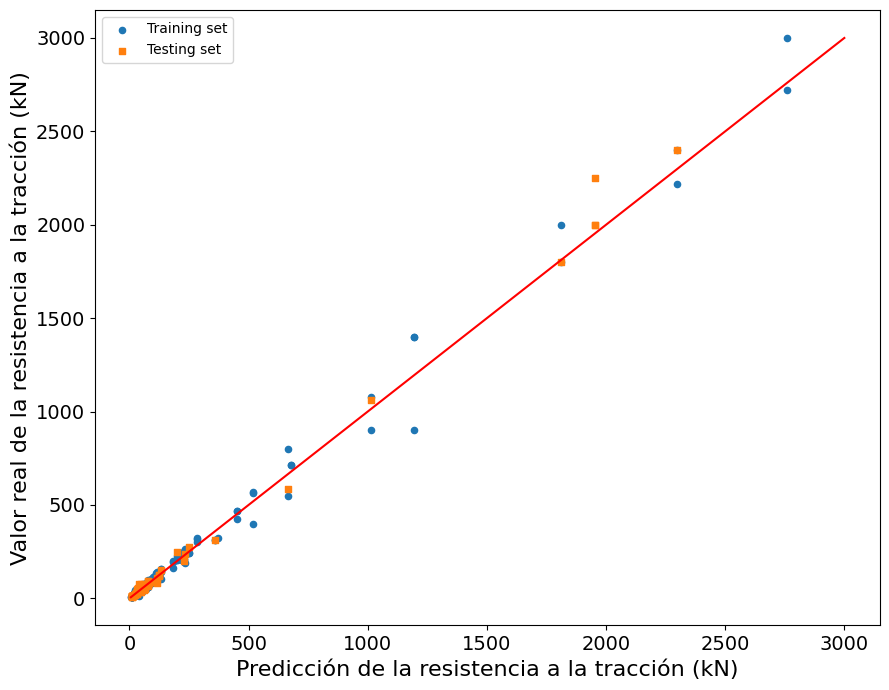

In [ ]:
YY_pred_final_normal = np.exp(YY_pred_final)
YY_train_final_normal = np.exp(YY_train_final)

YY_predtest_final_normal = np.exp(YY_predtest_final)
YY_test_final_normal = np.exp(YY_test_final)

Val_min = min(YY_train_final_normal.min(),YY_pred_final_normal.min(), YY_predtest_final_normal.min(),
              YY_test_final_normal.min())
Val_max = max(YY_train_final_normal.max(),YY_pred_final_normal.max(), YY_predtest_final_normal.max(),
              YY_test_final_normal.max())
plt.figure(figsize=(9,7))
plt.scatter(YY_pred_final_normal, YY_train_final_normal, label='Training set',s=20) # train
plt.scatter(YY_predtest_final_normal, YY_test_final_normal, marker="s",s=20,label='Testing set') # test
plt.plot(np.linspace(Val_min, Val_max, num=10),np.linspace(Val_min, Val_max, num=10), color='red')
plt.xlabel("Predicción de la resistencia a la tracción (kN)")
plt.ylabel("Valor real de la resistencia a la tracción (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
save_fig("Regression_FinalXGB_plot")



(400, 7)
Saving figure:  Regression_FinalModel_SHAP_summaryPlot1


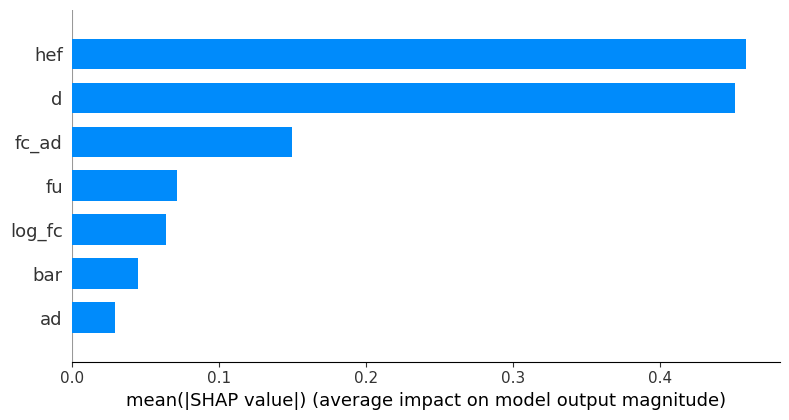

In [ ]:
#============ Part 8: Explainability of the final model with SHAP
# SHAP - final XGBOOST
# All Data
XX_alldata_sca = pd.DataFrame(X_data_slr.transform(X_data), columns = Input_var)
# Note: input features are in log and then scaled
# Note: The output of the model is log_Nu
#
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(XX_alldata_sca)
print(shap_values.shape)
file_table = path = os.path.join(TABLES_PATH, 'shap values.csv')
np.savetxt(file_table, shap_values, delimiter = ',')
# Global Explainability - Feature importance
feature_names_to_summaryplot = Input_var
shap.summary_plot(shap_values, data_mod_log[Input_var], plot_type="bar",
                  show=False, sort=True, feature_names=feature_names_to_summaryplot)
save_fig("Regression_FinalModel_SHAP_summaryPlot1")



Saving figure:  Regression_FinalModel_SHAP_summaryPlot2


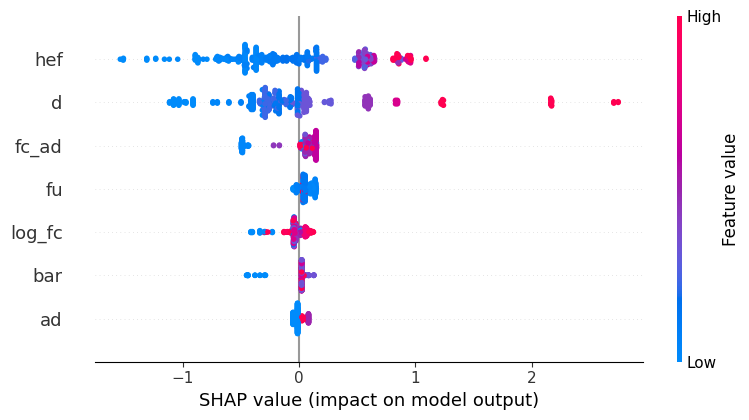

In [ ]:
# Global Explainability - SHAP summary plot
shap.summary_plot (shap_values, data_mod_log[Input_var],
                   show=False, sort=True, feature_names=feature_names_to_summaryplot)
save_fig("Regression_FinalModel_SHAP_summaryPlot2")
#

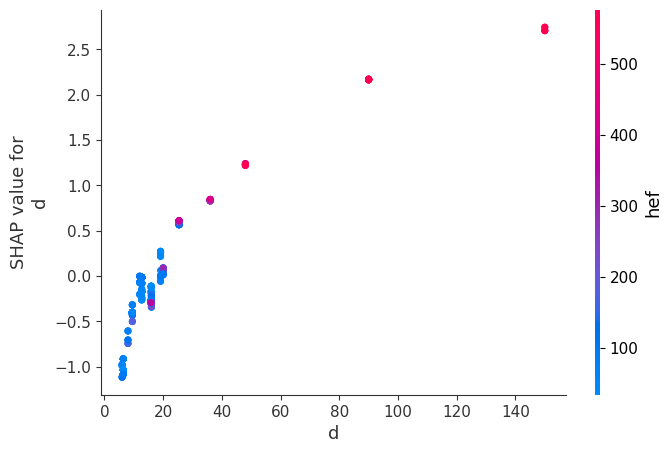

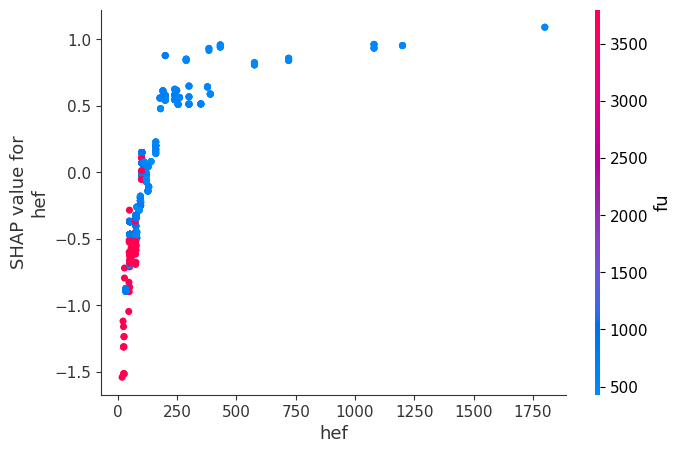

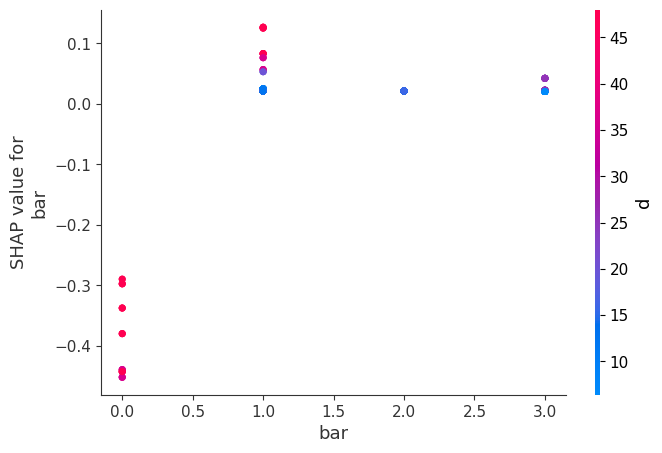

In [ ]:
# Global Explainability - Partial Dependency
plt.close('all')
shap.dependence_plot ('d', shap_values, data_mod_log[Input_var],
                      display_features=X_data, interaction_index='auto',
                      show=False, dot_size=26)
shap.dependence_plot ('hef', shap_values, data_mod_log[Input_var],
                      display_features=X_data, interaction_index='auto',
                      show=False, dot_size=26)
shap.dependence_plot ('bar', shap_values, data_mod_log[Input_var],
                      display_features=X_data, interaction_index='auto',
                      show=False, dot_size=26)

plt.show()


In [ ]:
#Encontrando los puntos alejados del gráfico
YY_train['Predic'] = YY_pred_final
YY_test['Predic'] = YY_predtest_final
YY_predicted_log = pd.concat([YY_train, YY_test])
YY_predicted_log = YY_predicted_log.sort_index()

YY_predicted_log.to_csv('data_log.csv', index=False)

YY_predicted_log

,log_Nu,Predic
0,5.488938,5.529201
1,5.488938,5.529201
2,5.609472,5.529201
3,6.146329,6.114098
4,6.146329,6.114098
...,...,...
395,4.410371,4.354655
396,4.245634,4.257588
397,4.517431,4.487478
398,4.483003,4.531605


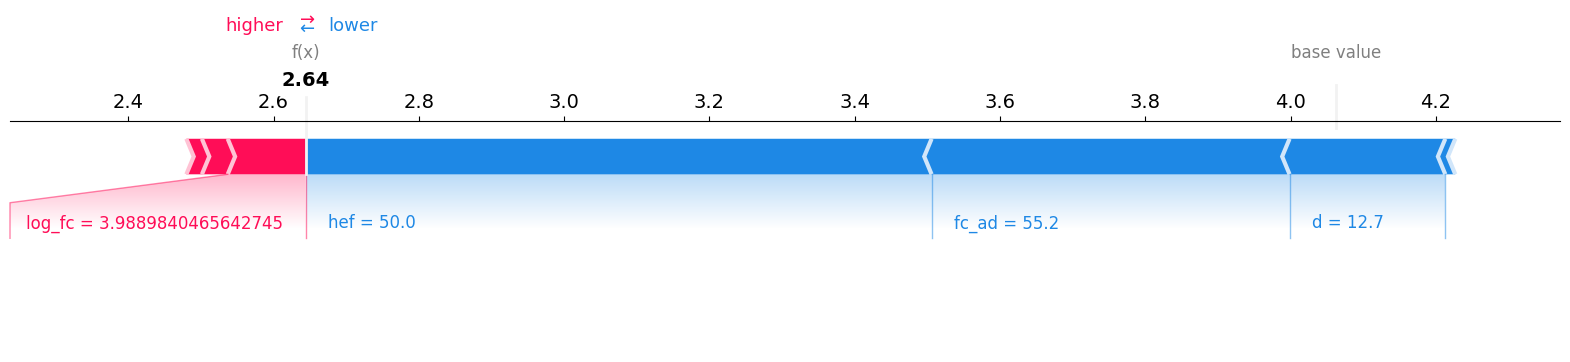

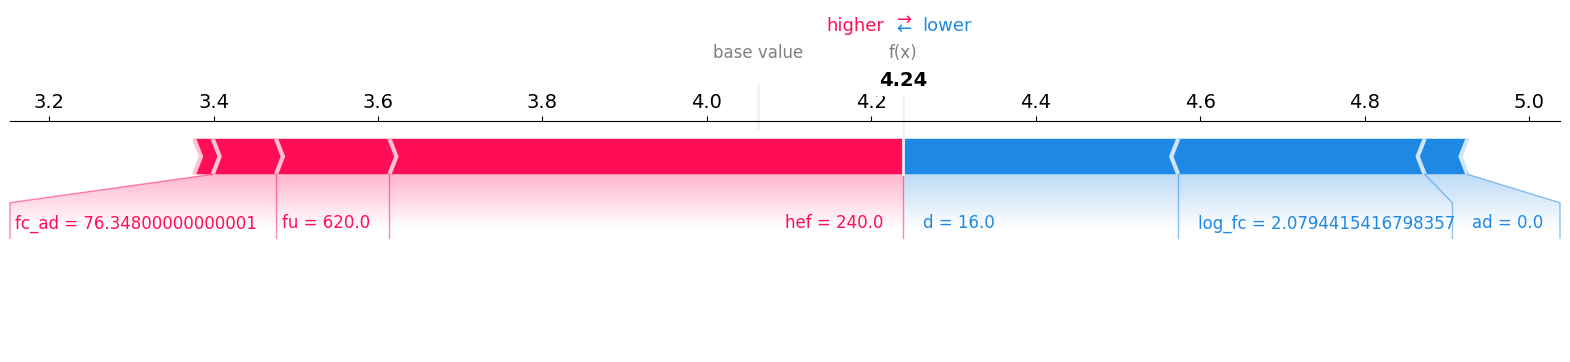

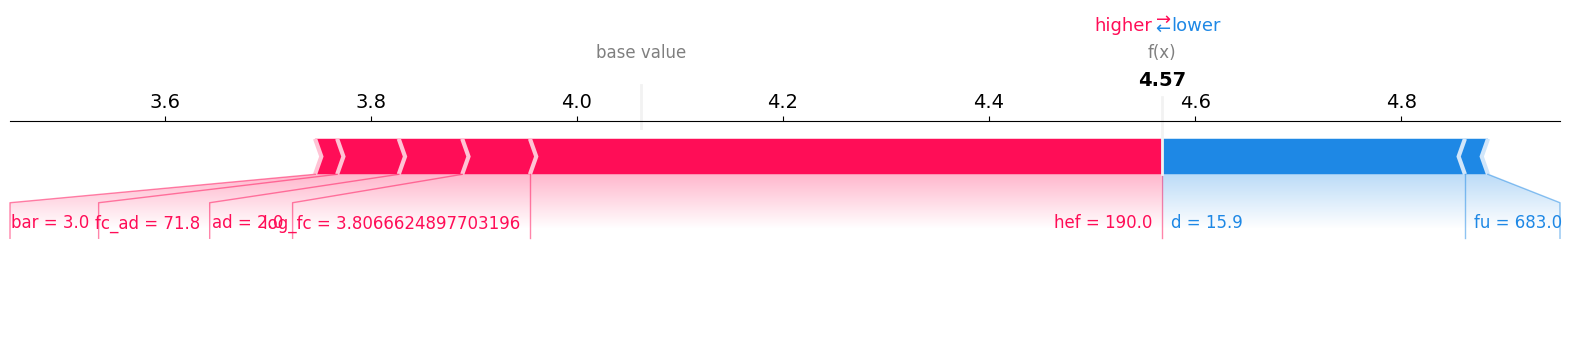

In [ ]:
# Local Explainability - Force Plots
columnas_reg = Input_var
# Sample 1 - Specimen 95
shap.force_plot(explainer.expected_value,shap_values[94],
                features=data_mod_log[Input_var].iloc[94],matplotlib=True,
                show=False)
#save_fig('Shap_force_Id200')
# Sample 2 - Specimen 380
shap.force_plot(explainer.expected_value,shap_values[379],
                features=data_mod_log[Input_var].iloc[379],matplotlib=True,
                show=False)
#save_fig('Shap_force_Id340')

shap.force_plot(explainer.expected_value,shap_values[200],
                features=data_mod_log[Input_var].iloc[200],matplotlib=True,
                show=False)
plt.show()

###Comparación con los métodos convencionales

In [ ]:
# =========== Part9: Comparison with conventional methods

def ACI349_method(hef, fc, d):
  p1 = 1 + d/hef
  N = 1.1328* np.sqrt(fc)* (hef**2) * p1
  return N/1000

def CCD_method (hef, fc):
  N = 15.9*np.sqrt(fc)* (hef**1.5)
  return N/1000

def ACI318 (d, fu, fc, hef):
  #Falla por tracción del acero
  A = np.pi*d**2 /4
  N1 = 0.75 * A * fu
  N1 = N1 / 1000

  #Falla arrancamiento del concreto
  yc = 1.4  #No fisurado y postinstalado
  lambd = 0.8 #Factor falla por concreto

  N2 =  0.65*7*lambd*yc*np.sqrt(fc)* (hef**1.5)
  N2 = N2 / 1000

  #Falla por adherencia
  lambd_adh = 0.6
  tao = 0.1*fc
  N3= 0.65* lambd_adh * tao * np.pi * d * hef
  N3 = N3

  N = min(N1, N2, N3)
  return N


In [ ]:
YY_train['Predic'] = YY_pred_final_normal
YY_test['Predic'] = YY_predtest_final_normal
YY_predicted = pd.concat([YY_train, YY_test])
YY_predicted = YY_predicted.sort_index()

YY_predicted

,log_Nu,Predic
0,5.488938,251.942535
1,5.488938,251.942535
2,5.609472,251.942535
3,6.146329,452.188019
4,6.146329,452.188019
...,...,...
395,4.410371,77.839951
396,4.245634,70.639389
397,4.517431,88.896996
398,4.483003,92.907532


In [ ]:
resultado_df = pd.DataFrame()

resultado_df['ACI_349'] = ACI349_method(data_comp['hef'], data_comp['fc'], data_comp['d'])
resultado_df['CCD'] = CCD_method(data_comp['hef'], data_comp['fc'])
resultado_df['ACI_318'] = data_comp.apply(lambda row: ACI318(row['d'], row['fu'], row['fc'], row['hef']), axis=1)
resultado_df['Real'] = data_comp['Nu']
resultado_df['ML'] = YY_predicted['Predic']

resultado_df

,ACI_349,CCD,ACI_318,Real,ML
0,528.519168,388.558005,124.534062,242.0,251.942535
1,528.519168,388.558005,124.534062,242.0,251.942535
2,528.519168,388.558005,124.534062,273.0,251.942535
3,528.519168,388.558005,124.534062,467.0,452.188019
4,528.519168,388.558005,124.534062,467.0,452.188019
...,...,...,...,...,...
395,113.680965,114.677696,36.754562,82.3,77.839951
396,113.680965,114.677696,36.754562,69.8,70.639389
397,161.220278,150.747746,48.315127,91.6,88.896996
398,161.220278,150.747746,48.315127,88.5,92.907532


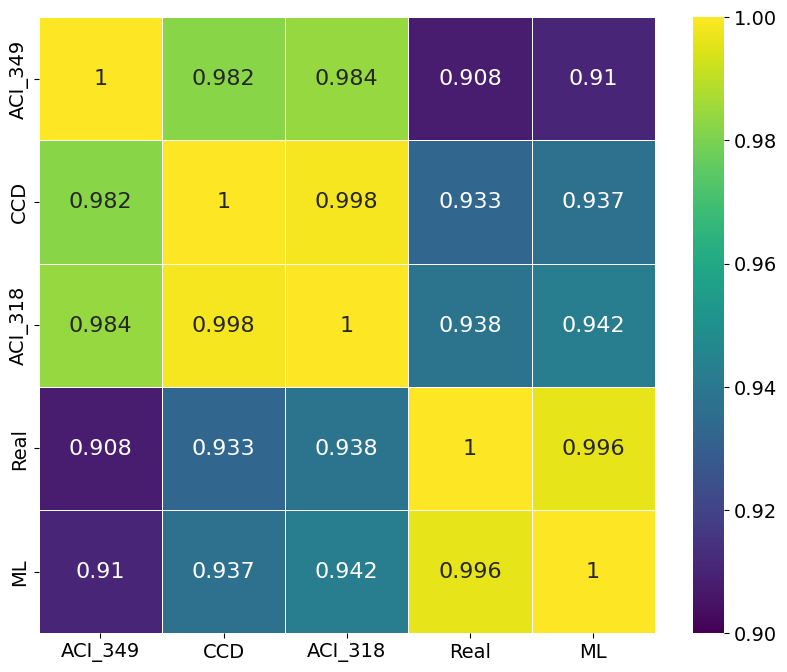

In [ ]:
# Visualization of correlation among conventional methods
names_num1 = ['ACI_349', 'CCD', 'ACI_318', 'Real', 'ML']

plt.figure(figsize=(10, 8))
sns.heatmap(resultado_df[names_num1].corr(), annot=True, fmt='.3g',
    cmap='viridis', vmax=1.0, vmin=0.9, linewidths=0.6, square=True,
            annot_kws={"size": 16}, xticklabels=names_num1, yticklabels=names_num1)
plt.show()

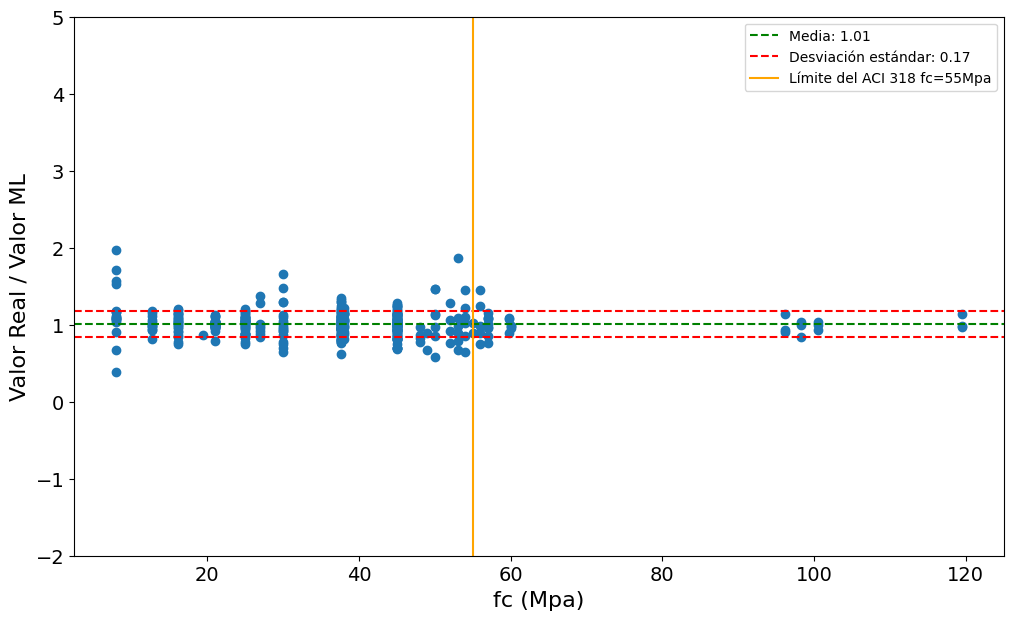

In [ ]:
#---------- Ploteo
array_predicted = resultado_df['ML'].to_numpy()
array_349 = resultado_df['ACI_349'].to_numpy()
array_ccd = resultado_df['CCD'].to_numpy()
array_318 = resultado_df['ACI_318'].to_numpy()
fc_normal = data_comp['fc'].to_numpy()


resultado_df['Ratio'] = resultado_df['Real']/ resultado_df['ML']
media_ratio = np.mean(resultado_df['Ratio'])
std = np.std(resultado_df['Ratio'])

# Gráfico de línea
plt.figure(figsize=(12, 7))
plt.scatter(x=fc_normal, y=resultado_df['Ratio'], marker='o')
plt.axhline(media_ratio, color='g', linestyle='--', label=f'Media: {media_ratio:.2f}')  # Línea de referencia en 1
plt.axhline(media_ratio + std, color='r', linestyle='--', label=f'Desviación estándar: {std:.2f}')
plt.axhline(media_ratio - std, color='r', linestyle='--')
plt.axvline(55, color = '#FFA500', label = f'Límite del ACI 318 fc=55Mpa')
plt.xlabel('fc (Mpa)')
plt.ylabel('Valor Real / Valor ML')
#plt.title('Razón entre V_predecido y V_real a lo largo de las Observaciones')
limite_superior = 5
limite_inferior = -2
plt.ylim(limite_inferior, limite_superior)
#plt.grid(True)
plt.legend()
plt.show()


<Figure size 1200x500 with 0 Axes>

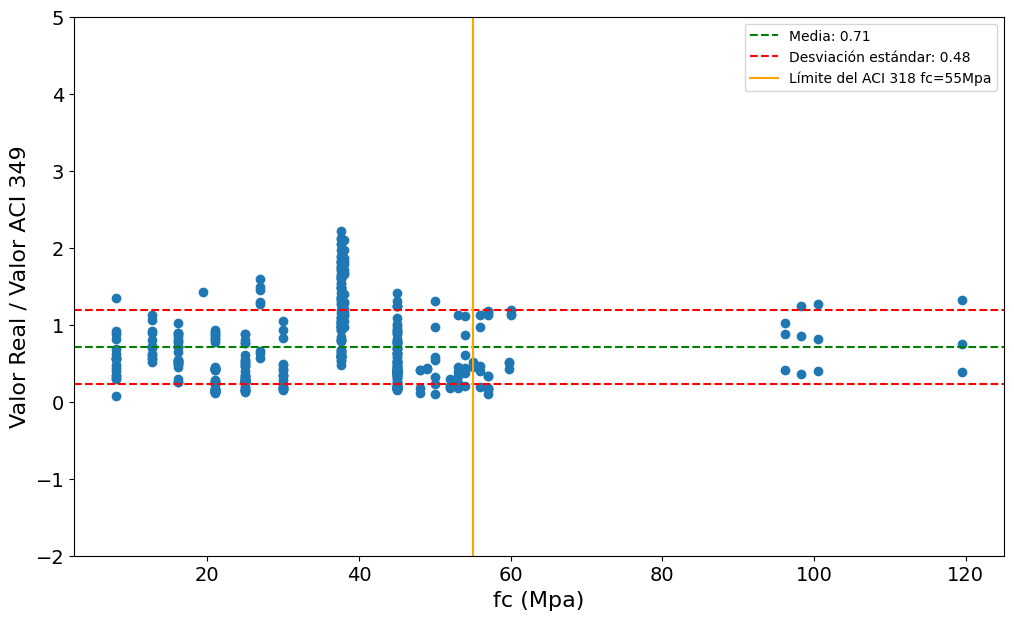

In [ ]:
#---------- Ploteo
plt.figure(figsize=(12,5))
resultado_df['Ratio'] = resultado_df['Real']/ resultado_df['ACI_349']
media_ratio = np.mean(resultado_df['Ratio'])
std = np.std(resultado_df['Ratio'])

# Gráfico de línea
plt.figure(figsize=(12, 7))
plt.scatter(x=fc_normal, y=resultado_df['Ratio'], marker='o')
plt.axhline(media_ratio, color='g', linestyle='--', label=f'Media: {media_ratio:.2f}')  # Línea de referencia en 1
plt.axhline(media_ratio + std, color='r', linestyle='--', label=f'Desviación estándar: {std:.2f}')
plt.axhline(media_ratio - std, color='r', linestyle='--')
plt.axvline(55, color = '#FFA500', label = f'Límite del ACI 318 fc=55Mpa')
plt.xlabel('fc (Mpa)')
plt.ylabel('Valor Real / Valor ACI 349')
#plt.title('Razón entre V_predecido y V_real a lo largo de las Observaciones')
limite_superior = 5
limite_inferior = -2
plt.ylim(limite_inferior, limite_superior)
#plt.grid(True)
plt.legend()
plt.show()


<Figure size 700x500 with 0 Axes>

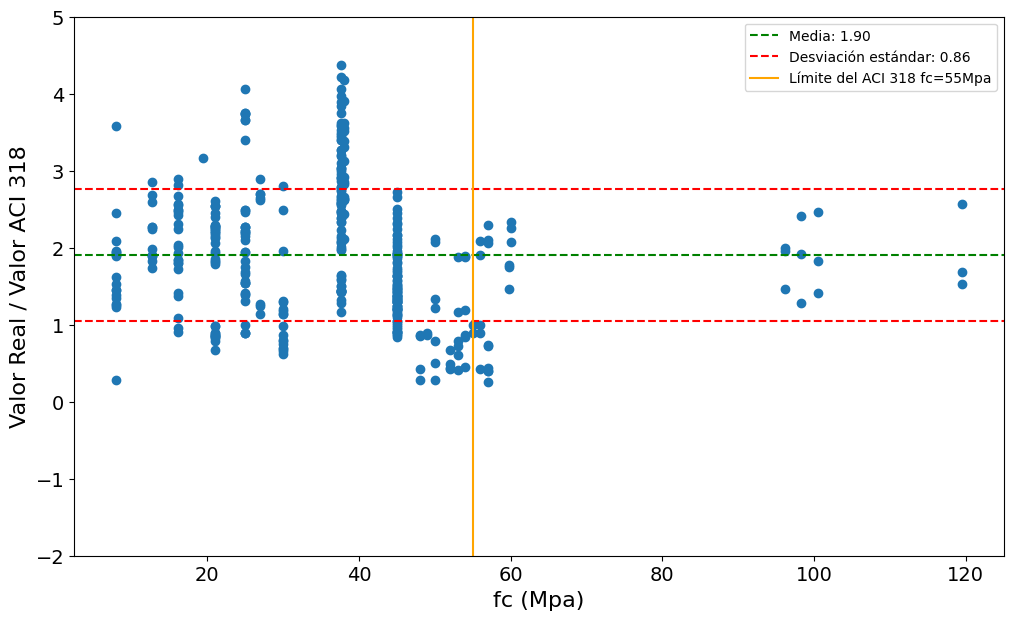

In [ ]:
#---------- Ploteo
plt.figure(figsize=(7,5))
resultado_df['Ratio'] = resultado_df['Real']/ resultado_df['ACI_318']
media_ratio = np.mean(resultado_df['Ratio'])
std = np.std(resultado_df['Ratio'])

# Gráfico de línea
plt.figure(figsize=(12, 7))
plt.scatter(x=fc_normal, y=resultado_df['Ratio'], marker='o')
plt.axhline(media_ratio, color='g', linestyle='--', label=f'Media: {media_ratio:.2f}')  # Línea de referencia en 1
plt.axhline(media_ratio + std, color='r', linestyle='--', label=f'Desviación estándar: {std:.2f}')
plt.axhline(media_ratio - std, color='r', linestyle='--')
plt.axvline(55, color = '#FFA500', label = f'Límite del ACI 318 fc=55Mpa')
plt.xlabel('fc (Mpa)')
plt.ylabel('Valor Real / Valor ACI 318')
#plt.title('Razón entre V_predecido y V_real a lo largo de las Observaciones')
limite_superior = 5
limite_inferior = -2
plt.ylim(limite_inferior, limite_superior)
#plt.grid(True)
plt.legend()
plt.show()


<Figure size 700x500 with 0 Axes>

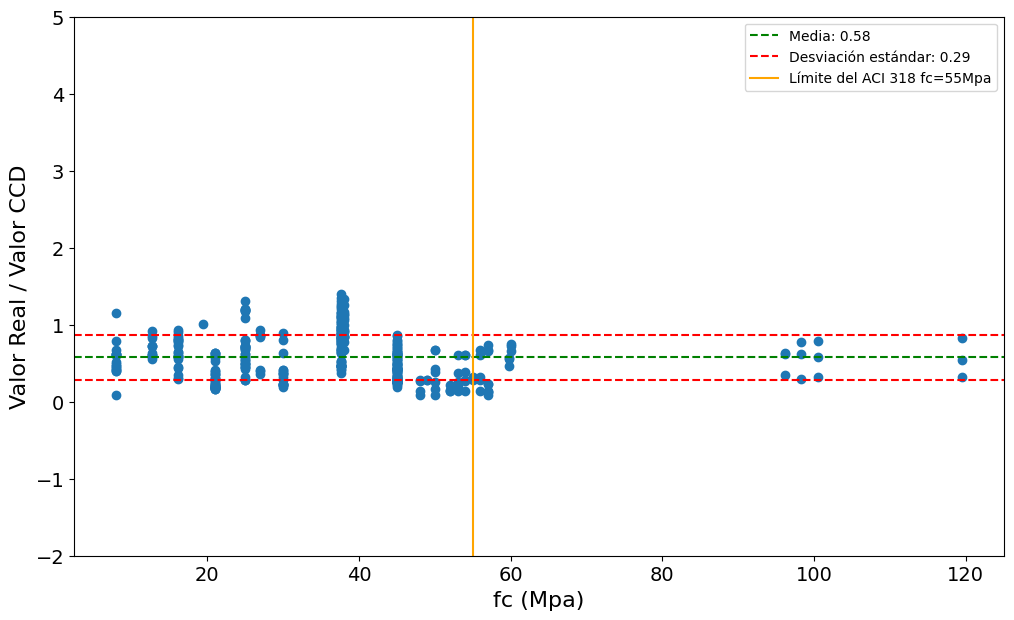

In [ ]:
#---------- Ploteo
plt.figure(figsize=(7,5))
resultado_df['Ratio'] = resultado_df['Real']/ resultado_df['CCD']
media_ratio = np.mean(resultado_df['Ratio'])
std = np.std(resultado_df['Ratio'])

# Gráfico de línea
plt.figure(figsize=(12, 7))
plt.scatter(x=fc_normal, y=resultado_df['Ratio'], marker='o')
plt.axhline(media_ratio, color='g', linestyle='--', label=f'Media: {media_ratio:.2f}')  # Línea de referencia en 1
plt.axhline(media_ratio + std, color='r', linestyle='--', label=f'Desviación estándar: {std:.2f}')
plt.axhline(media_ratio - std, color='r', linestyle='--')
plt.axvline(55, color = '#FFA500', label = f'Límite del ACI 318 fc=55Mpa')
plt.xlabel('fc (Mpa)')
plt.ylabel('Valor Real / Valor CCD')
#plt.title('Razón entre V_predecido y V_real a lo largo de las Observaciones')
limite_superior = 5
limite_inferior = -2
plt.ylim(limite_inferior, limite_superior)
#plt.grid(True)
plt.legend()
plt.show()


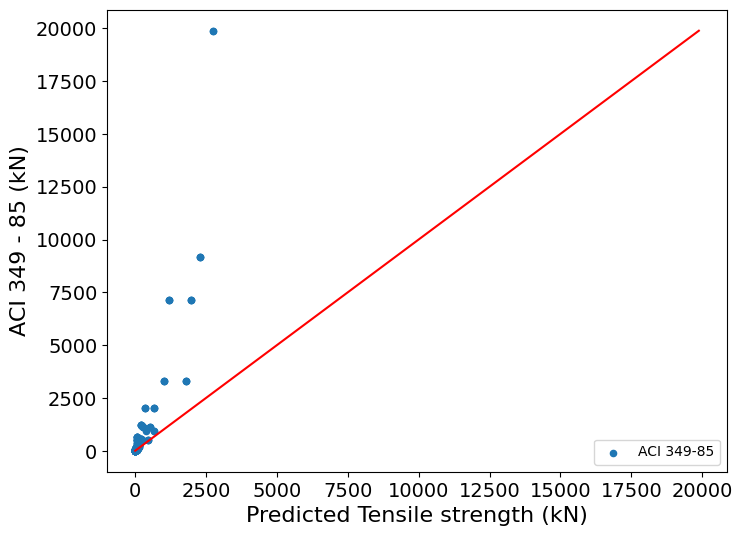

In [ ]:
#---------- Ploteo
plt.figure(figsize=(8,6))

Val_min = min(array_predicted.min(),array_349.min())
Val_max = max(array_predicted.max(),array_349.max())

plt.scatter(array_predicted, array_349,s=20 , label='ACI 349-85') # ACI 349
#plt.scatter(array_predicted, array_ccd, marker="s",s=20,label='CCD') # CCD
#plt.scatter(array_predicted, array_318 , marker="^",s=20,label='ACI 318') # CCD
plt.plot(np.linspace(Val_min, Val_max, num=10),np.linspace(Val_min, Val_max, num=10), color='r')
corr = np.corrcoef(array_predicted,array_349)[0, 1]
plt.xlabel("Predicted Tensile strength (kN)")
plt.ylabel("ACI 349 - 85 (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
plt.show()

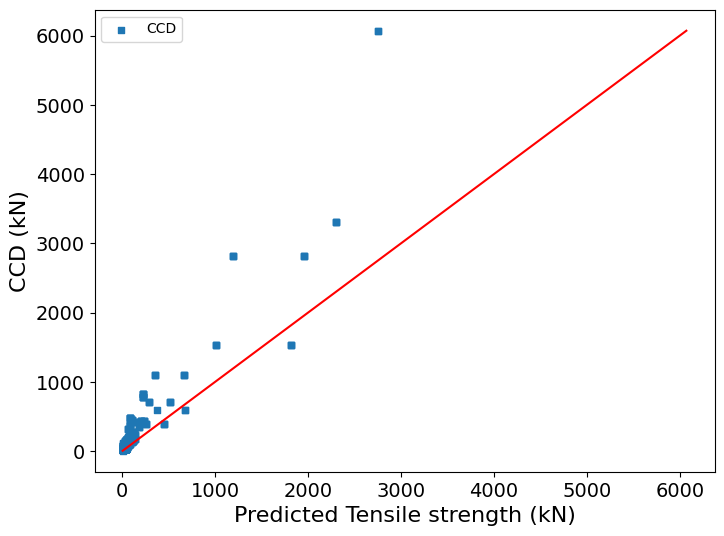

In [ ]:
#---------- Ploteo
plt.figure(figsize=(8,6))

Val_min = min(array_predicted.min(),array_ccd.min())
Val_max = max(array_predicted.max(),array_ccd.max())

#plt.scatter(array_predicted, array_349, label='ACI 349-85',s=20) # ACI 349
plt.scatter(array_predicted, array_ccd, marker="s",s=20,label='CCD') # CCD
#plt.scatter(array_predicted, array_318 , marker="^",s=20,label='ACI 318') # CCD
plt.plot(np.linspace(Val_min, Val_max, num=10),np.linspace(Val_min, Val_max, num=10), color='r')
corr = np.corrcoef(array_predicted,array_349)[0, 1]
plt.xlabel("Predicted Tensile strength (kN)")
plt.ylabel("CCD (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
plt.show()

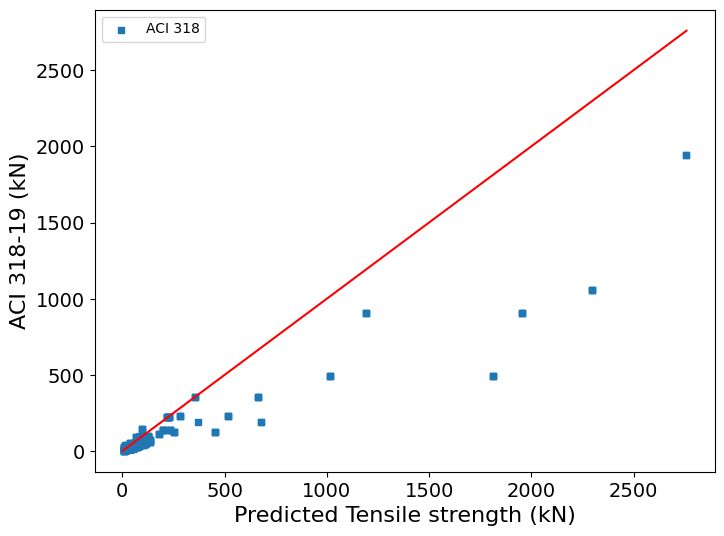

In [ ]:
#---------- Ploteo
plt.figure(figsize=(8,6))

Val_min = min(array_predicted.min(),array_318.min())
Val_max = max(array_predicted.max(),array_318.max())

#plt.scatter(array_predicted, array_349, label='ACI 349-85',s=20) # ACI 349
#plt.scatter(array_predicted, array_ccd, marker="s",s=20,label='CCD') # CCD
plt.scatter(array_predicted, array_318 , marker="s",s=20,label='ACI 318') # CCD
plt.plot(np.linspace(Val_min, Val_max, num=10),np.linspace(Val_min, Val_max, num=10), color='red')
corr = np.corrcoef(array_predicted,array_318)[0, 1]
plt.xlabel("Predicted Tensile strength (kN)")
plt.ylabel("ACI 318-19 (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
plt.show()

In [66]:
def app_adhesive(d_, hef_, ad_, fc_ad_, fc_, bar_, fu_):
  loga_fc = np.log(fc_)

  data = {
      'd' : d_,
      'hef' : hef_,
      'ad' : ad_,
      'fc_ad' : fc_ad_,
      'log_fc' : loga_fc,
      'bar' : bar_,
      'fu' : fu_
  }
  print(f'data: {data}')
  In_var = ['d', 'hef','ad', 'fc_ad', 'log_fc', 'bar', 'fu']

  datos_x = pd.DataFrame(data, index = [0])
  print(f'datos_x: {datos_x}')

  sca_datos_x = pd.DataFrame(X_data_slr.transform(datos_x),columns = In_var)
  print(f'sca_datos_x: {sca_datos_x}')

  Nu_pred = final_model.predict(sca_datos_x)
  print(Nu_pred)
  Nu_pred_ = np.exp(Nu_pred)

  return Nu_pred_


data: {'d': 15.9, 'hef': 300, 'ad': 0, 'fc_ad': 82.7, 'log_fc': 3.044522437723423, 'bar': 1, 'fu': 620}
datos_x:       d  hef  ad  fc_ad    log_fc  bar   fu
0  15.9  300   0   82.7  3.044522    1  620
sca_datos_x:           d       hef        ad     fc_ad   log_fc       bar        fu
0 -0.186482  0.529773 -0.479441  1.115377 -0.82817 -0.584198 -0.447057
[4.3613005]


array([78.35898], dtype=float32)

In [ ]:
# =========== Part9:  Predictions for a new dataset (only TARUHPC samples) ====
FEM_data = pd.read_csv('database_FEM_1.csv', delimiter=",")
print(FEM_data.head(5))
print(FEM_data.info())

      d    hef  ad  fc_ad  fc  bar    fu     Nu
0  12.7   76.2   0     50  30    1  1034  57.12
1  12.7  101.6   0     50  30    1  1034  80.45
2  12.7  127.0   0     50  30    1  1034  95.72
3  12.7  152.4   0     50  30    1  1034  96.79
4  12.7   76.2   0     50  30    1  1034  63.33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   d       72 non-null     float64
 1   hef     72 non-null     float64
 2   ad      72 non-null     int64  
 3   fc_ad   72 non-null     int64  
 4   fc      72 non-null     int64  
 5   bar     72 non-null     int64  
 6   fu      72 non-null     int64  
 7   Nu      72 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 4.6 KB
None


In [ ]:
print(var_names_to_log)

['fc', 'Nu']


In [ ]:
# Preparing data for predictions
print(var_names_to_log)
FEM_data_log = FEM_data.copy()
for feature in var_names_to_log:
    FEM_data_log[feature] = np.log(FEM_data_log[feature])
print(names_num)
FEM_data_log.columns = names_num
FEM_data_log

['fc', 'Nu']
['d', 'hef', 'ad', 'fc_ad', 'log_fc', 'bar', 'fu', 'log_Nu']


,d,hef,ad,fc_ad,log_fc,bar,fu,log_Nu
0,12.7,76.2,0,50,3.401197,1,1034,4.045154
1,12.7,101.6,0,50,3.401197,1,1034,4.387636
2,12.7,127.0,0,50,3.401197,1,1034,4.561427
3,12.7,152.4,0,50,3.401197,1,1034,4.572544
4,12.7,76.2,0,50,3.401197,1,1034,4.148359
...,...,...,...,...,...,...,...,...
67,19.1,152.4,0,50,3.401197,1,1034,5.456090
68,19.1,76.2,0,50,3.401197,1,1034,5.570975
69,19.1,101.6,0,50,3.401197,1,1034,5.578181
70,19.1,127.0,0,50,3.401197,1,1034,5.583985


In [ ]:
# Transforming data
X2_data = FEM_data_log[Input_var]
Y2_data = FEM_data_log[Target_var]
print(X2_data.head())
# Scaling new data
X2_data_sca = pd.DataFrame(X_data_slr.transform(X2_data),columns = Input_var)
X2_data_sca

      d    hef  ad  fc_ad    log_fc  bar    fu
0  12.7   76.2   0     50  3.401197    1  1034
1  12.7  101.6   0     50  3.401197    1  1034
2  12.7  127.0   0     50  3.401197    1  1034
3  12.7  152.4   0     50  3.401197    1  1034
4  12.7   76.2   0     50  3.401197    1  1034


,d,hef,ad,fc_ad,log_fc,bar,fu
0,-0.339689,-0.463572,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
1,-0.339689,-0.350833,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
2,-0.339689,-0.238094,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
3,-0.339689,-0.125356,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
4,-0.339689,-0.463572,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
...,...,...,...,...,...,...,...
67,-0.033275,-0.125356,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
68,-0.033275,-0.463572,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
69,-0.033275,-0.350833,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888
70,-0.033275,-0.238094,-0.479441,-1.996747,-0.144291,-0.584198,-0.068888


In [ ]:
# Estimating the metrics
Y2_pred = final_model.predict(X2_data_sca)
Y2_real = Y2_data['log_Nu']
#
FEM_rmse = rmse_LOG(Y2_real, Y2_pred)
FEM_R2 = r2_LOG(Y2_real, Y2_pred)
FEM_mard=mard_LOG(Y2_real, Y2_pred)
FEM_D=D_percentage_LOG(Y2_real, Y2_pred,25)
print('FEM Dataset')
print("Root_mean_squared_error: ", FEM_rmse)
print("R2: ", FEM_R2)
print("MARD: ", FEM_mard)
print("D%: ", FEM_D)

FEM Dataset
Root_mean_squared_error:  92.48327496124969
R2:  -2.043275894114477
MARD:  0.6022574093309296
D%:  11.11111111111111


In [ ]:
# Final predictions on TARUHPC samples
print(Y2_pred)

[3.5043774 4.239293  4.1718793 4.366774  3.5043774 4.239293  4.1718793
 4.366774  3.5043774 4.239293  4.1718793 4.366774  3.5043774 4.239293
 4.1718793 4.366774  3.5043774 4.239293  4.1718793 4.366774  3.5043774
 4.239293  4.1718793 4.366774  3.1972883 3.926553  3.8812613 4.1575522
 3.1972883 3.926553  3.8812613 4.1575522 3.1972883 3.926553  3.8812613
 4.1575522 3.1972883 3.926553  3.8812613 4.1575522 3.1972883 3.926553
 3.8812613 4.1575522 3.1972883 3.926553  3.8812613 4.1575522 3.3780992
 4.107363  4.0620723 4.425921  3.3780992 4.107363  4.0620723 4.425921
 3.3780992 4.107363  4.0620723 4.425921  3.3780992 4.107363  4.0620723
 4.425921  3.3780992 4.107363  4.0620723 4.425921  3.3780992 4.107363
 4.0620723 4.425921 ]


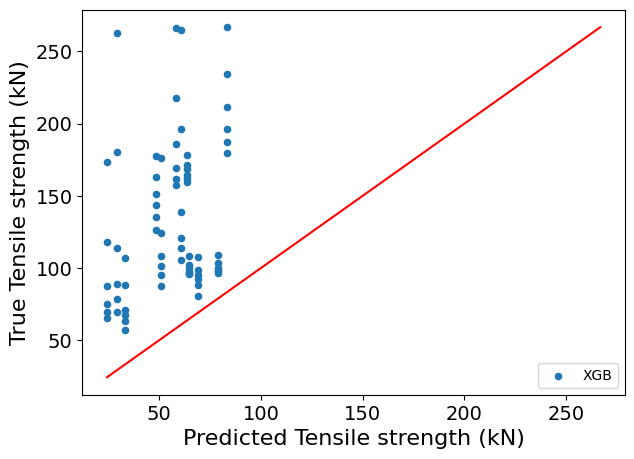

In [ ]:
# Plot of prediction
plt.close('all')
Y2_real = np.exp(Y2_real)
Y2_pred = np.exp(Y2_pred)
Val_min = min(Y2_real.min(),Y2_pred.min())
Val_max = max(Y2_real.max(),Y2_pred.max())
plt.figure(figsize=(7,5))
plt.scatter(Y2_pred, Y2_real, label='XGB',s=20)
plt.plot(np.linspace(Val_min, Val_max, num=10),
         np.linspace(Val_min, Val_max, num=10), color='red')
plt.xlabel("Predicted Tensile strength (kN)")
plt.ylabel("True Tensile strength (kN)")
plt.xticks()
plt.yticks()
plt.legend()
plt.grid(False)
plt.show()
#save_fig("Regression_FinalXGB_plot")